## Final Project: Prediksi Harga Saham Bank di Indonesia

**Karina Anggraeni - JCDSAH BSD** </br>
Dataset diambil dari aplikasi Neo HOTS (Mirae Asset Sekuritas)

Data harga saham bank yang digunakan dalam dataset ini adalah data terhadap bank swasta nasional, bank swasta asing, dan bank milik negara, yaitu:
- Bank Central Asia (BBCA) dan Bank Mega (MEGA) - swasta nasional
- Bank Woori Saudara (SDRA) dan MayBank (BNII) - swasta asing
- Bank Rakyat Indonesia (BRII) dan Bank Mandiri (BMRI) - negara

### [PART 3: Stock Price Prediction - BBRI]

### 4. Modeling and Evaluation

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
from statsmodels.tsa.stattools import adfuller
from IPython.core.debugger import set_trace
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from IPython import display

import warnings
warnings.filterwarnings('ignore')

#### B. BBRI Stock Prediction

In [2]:
bbri = pd.read_csv('df_bbri.csv', index_col = 'Date')

In [3]:
bbri_train_len = math.ceil(len(bbri)*0.8)
bbri_train_len

969

#### B.1. ARIMA Model

**ADF Stationary Test**

Augumented Dickey Fuller Test (ADF Test) digunakan untuk memeriksa stationer/ tidaknya suatu data. Test ini biasanya digunakan dalam ARIMA untuk time-series karena model ARIMA akan bekerja lebih baik pada data yang bersifat stationer.

In [4]:
bbri_adf = adfuller(bbri)

print(f'ADF Statistics: {bbri_adf[0]}')

if bbri_adf[1] > 0.05:
    print(f'p-value: {bbri_adf[1]}, data is stationary.')
else:
    print(f'p-value: {bbri_adf[1]}, data is non-stationary.')

ADF Statistics: -1.2732817558735006
p-value: 0.6413055936839371, data is stationary.


Karena nilai p-value dari ADF Test terhadap BBRI melebihi 0.05 (p-value > 0.05), maka dapat disimpulkan data yang kita miliki tidak stationer.

**Manual Parameter Tuning**

Pada model ARIMA, terdapat 3 jenis parameter yang dibutuhkan ketika melakukan modeling, yaitu: </br>
- **p** menyatakan nilai variabel AR (Auto Regressive Variable/ Lag Variable) atau berapa banyak data periode sebelumnya yang akan digunakan dalam feature </br>
- **d** menyatakan nilai variabel I (Integrated Variable) atau berapa banyak diferensiasi yang perlu dilakukan agar data time-series menjadi stationer </br>
- **p** menyatakan nilai variabel MA (Moving Average Variable)

Nilai p, d, dan q dapat kita estimasi menggunakan plot ACF dan  PACF.

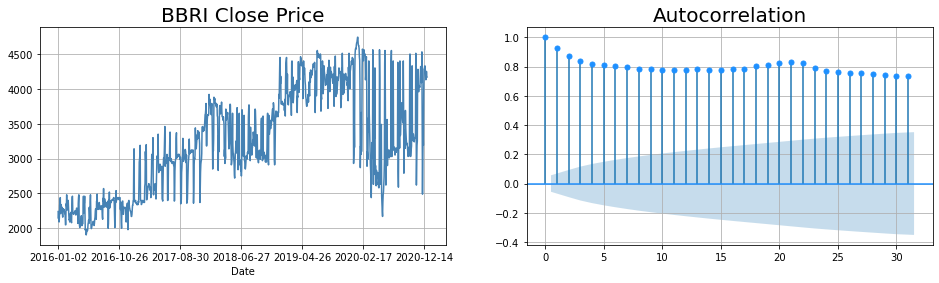

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bbri['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BBRI Close Price', size = 20)
ax1.grid()

plot_acf(bbri['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Autocorrelation', size = 20)
ax2.grid()

plt.show()

Kita akan menentukan banyaknya diferensiasi yang diperlukan dengan menggunakan _ndiffs_ dari package pmdarima.

In [6]:
ndiffs(bbri['Close'], test = 'adf')

0

Karena nilai _ndiifs_ adalah 0, berarti data harga `Close` BBRI yang kita miliki tidak perlu didiferensiasi.

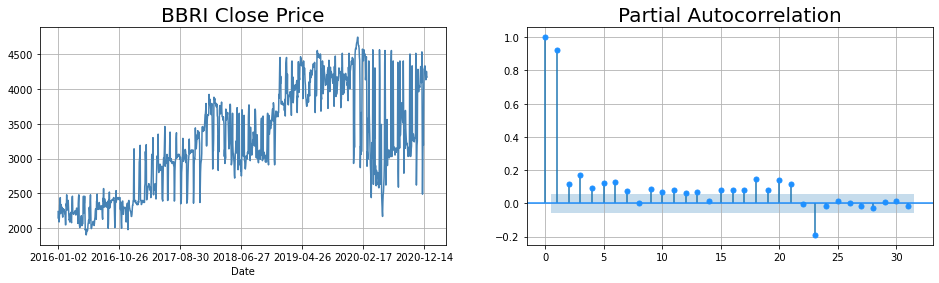

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
bbri['Close'].plot(color = 'steelblue', ax = ax1)
ax1.set_title('BBRI Close Price', size = 20)
ax1.grid()

plot_pacf(bbri['Close'], color = 'dodgerblue', ax = ax2)
ax2.set_title('Partial Autocorrelation', size = 20)
ax2.grid()

plt.show()

Dari plot PACF, kita pilih nilai p = 1 (nilai yang melebihi area yang diarsir/ significance line) dan nilai q = 8 (nilai yang berada di dalam significance line).

Sehingga kita dapatkan **p = 1**, **d = 0**, dan **q = 8**.

**Train Test Split**

In [8]:
bbri_arima_train = bbri['Close'][:bbri_train_len]
bbri_arima_valid = bbri['Close'][bbri_train_len:]

**Model Fitting and Evaluation**

In [9]:
bbri_arima = ARIMA(bbri_arima_train, order = (1, 0, 8))
bbri_arima_result = bbri_arima.fit()

bbri_arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(1, 0, 8)   Log Likelihood               -6404.301
Date:                Tue, 13 Apr 2021   AIC                          12830.601
Time:                        14:21:51   BIC                          12884.240
Sample:                             0   HQIC                         12851.019
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3146.4869    838.979      3.750      0.000    1502.119    4790.855
ar.L1          0.9994      0.002    585.304      0.000       0.996       1.003
ma.L1         -0.2800      0.029     -9.719      0.000      -0.336      -0.224
ma.L2         -0.2129      0.031     -6.798      0.000      -0.274      -0.151
ma.L3         -0.1396      0.032     -4.358      0.000      -0.202      -0.077
ma.L4         -0.1146      0.033     -3.487      0.000      -0.179      -0.050
ma.L5         -0.0604      0.036     -1.668      0.095      -0.131       0.011
ma.L6         -0.0086      0.036     -0.240      0.811      -0.079       0.062
ma.L7         -0.0165      0.038     -0.437      0.662      -0.091       0.058
ma.L8          0.0045      0.035      0.130      0.896      -0.063       0.073
sigma2      3.251e+04   1079.124     30.130      0.000    3.04e+04    3.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               452.28
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
steps = len(bbri_arima_valid)

fc = bbri_arima_result.forecast(steps)
fc_series = pd.DataFrame(fc)

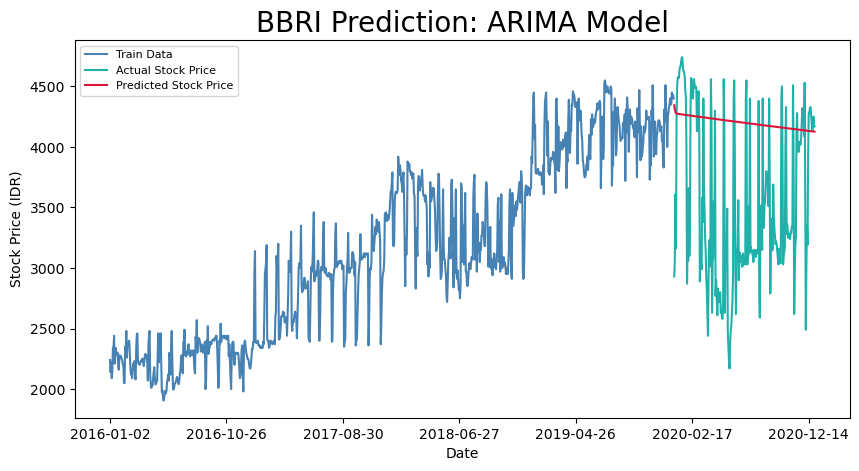

In [11]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bbri_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bbri_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BBRI Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [12]:
mse = mean_squared_error(bbri_arima_valid, fc)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bbri_arima_valid, fc))
print(f'RMSE: {rmse}')

MSE: 896730.0954665006
RMSE: 946.9583388230449


**Auto ARIMA Tuning**

In [13]:
model_autoARIMA = auto_arima(bbri_arima_train, start_p = 0, start_q = 0,
                      test = 'adf',       # use adftest to find optimal 'd'
                      max_p = 15, max_q = 15, # maximum p and q
                      m = 1,              # frequency of series
                      d = None,           # let model determine 'd'
                      seasonal = False,   # No Seasonality
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18412.362, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=17161.651, Time=0.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12933.557, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12868.696, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12823.698, Time=0.50 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=12824.559, Time=0.62 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.93 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12832.186, Time=0.56 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12836.713, Time=1.07 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fi

In [14]:
bbri_arima_tuned = ARIMA(bbri_arima_train, order = (3, 0, 1))
bbri_arima_tuned_result = bbri_arima_tuned.fit()

bbri_arima_tuned_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  969
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -6405.481
Date:                Tue, 13 Apr 2021   AIC                          12822.963
Time:                        14:22:00   BIC                          12852.221
Sample:                             0   HQIC                         12834.100
                                - 969                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3146.4950    894.447      3.518      0.000    1393.410    4899.580
ar.L1          1.6549      0.032     51.271      0.000       1.592       1.718
ar.L2         -0.7056      0.054    -13.077      0.000      -0.811      -0.600
ar.L3          0.0504      0.032      1.570      0.116      -0.013       0.113
ma.L1         -0.9326      0.016    -56.583      0.000      -0.965      -0.900
sigma2      3.217e+04   1039.246     30.952      0.000    3.01e+04    3.42e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               456.17
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
steps = len(bbri_arima_valid)

fc_tuned = bbri_arima_tuned_result.forecast(steps, alpha = 0.05)
fc_series_tuned = pd.DataFrame(fc_tuned)

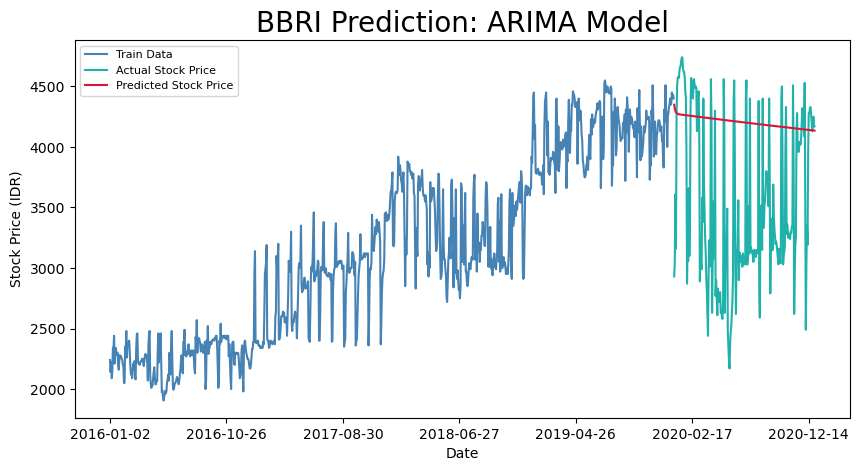

In [16]:
plt.figure(figsize = (10,5), dpi = 100)
plt.plot(bbri_arima_train, label = 'Train Data', color = 'steelblue')
plt.plot(bbri_arima_valid, label = 'Actual Stock Price', color = 'lightseagreen')
plt.plot(fc_series_tuned, label = 'Predicted Stock Price', color = 'crimson')
plt.title('BBRI Prediction: ARIMA Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.savefig('BBRI ARIMA.png')
plt.show()

In [17]:
mse_tuned = mean_squared_error(bbri_arima_valid, fc_tuned)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bbri_arima_valid, fc_tuned))
print(f'RMSE: {rmse_tuned}')

MSE: 900842.4705299708
RMSE: 949.1272151455624


**Result Comparison**

In [18]:
pd.set_option('display.float_format', '{:.2f}'.format)
arima_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Manual Tuning' : [mse, rmse], 'Auto ARIMA Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(arima_compare)

,Evaluation Method,Manual Tuning,Auto ARIMA Tuning
0,MSE,896730.10,900842.47
1,RMSE,946.96,949.13


In [19]:
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah {round(rmse/ bbri_arima_valid.mean(), 5)}.')
print(f'Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah {round(rmse_tuned/ bbri_arima_valid.mean(), 5)}.')

Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah 0.26891.
Rasio RMSE (Auto ARIMA Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah 0.26952.


Prediksi harga saham BBRI menggunakan model ARIMA dengan Manual Tuning memberikan hasil prediksi yang paling baik.

#### B.2. LSTM Model

In [20]:
bbri_array = bbri.filter(['Close']).values
bbri_array.shape

(1211, 1)

**Feature Engineering**

In [21]:
scaler = MinMaxScaler()
bbri_scaled = scaler.fit_transform(bbri_array)

**Data Splitting**

In [22]:
bbri_lstm_train = bbri_scaled[0:bbri_train_len, :]

bbri_lstm_x_train, bbri_lstm_y_train = [], []

for i in range(51, bbri_train_len):
    bbri_lstm_x_train.append(bbri_lstm_train[i-51:i, :])
    bbri_lstm_y_train.append(bbri_lstm_train[i, :])

LSTM menerima input data dalam bentuk 3D array, sehingga training data yang akan kita fit ke dalam model harus berbentuk array.

In [23]:
bbri_lstm_x_train, bbri_lstm_y_train = np.array(bbri_lstm_x_train), np.array(bbri_lstm_y_train)

In [24]:
print(f'Shape of x train: {bbri_lstm_x_train.shape}')
print(f'Shape of y train: {bbri_lstm_y_train.shape}')

Shape of x train: (918, 51, 1)
Shape of y train: (918, 1)


**Model Fitting**

Dalam LSTM, terdapat beberapa parameter yang perlu ditentukan terlebih dahulu, yaitu:
- **Hidden Layer** : banyaknya jumlah neuron yang akan digunakan dalam model
- **Dropout** : besarnya peluang model 'melupakan' informasi yang kurang penting dari neuron sebelumnya (saya menggunakan 0.2)
- **History Points** : banyaknya data yang digunakan dalam training untuk satu kali iterasi (saya membagi data training yang totalnya berjumlah 969 data ke dalam 17 iterasi, dengan masing-masing 51 history points per iterasi)
- **Feature Number** : banyaknya feature yang digunakan (dalam hal ini hanya ada 1 feature)
- **Optimizer** (biasanya digunakan optimizer _Adam_)

In [25]:
bbri_lstm = Sequential()
bbri_lstm.add(LSTM(50, return_sequences = False, input_shape = (bbri_lstm_x_train.shape[1], 1)))
bbri_lstm.add(Dropout(0.2))
bbri_lstm.add(Dense(bbri_lstm_y_train.shape[1]))

bbri_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

Jumlah batch size dan epoch yang umumnya digunakan untuk data kecil (ukuran data masih berjumlah ribuan) adalah 32 dan 100.

In [26]:
bbri_lstm.fit(bbri_lstm_x_train, bbri_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 6s 25ms/step - loss: 0.0654
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0121
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0094
Epoch 4/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0073
Epoch 5/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0082
Epoch 6/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0087
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0088
Epoch 8/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0082
Epoch 9/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0072
Epoch 10/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0081
Epoch 11/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0087
Epoch 12/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0081
Epoch 13/100
29/29 [=====

**Predictions**

In [27]:
bbri_lstm_test = bbri_scaled[bbri_train_len - 51:, :]
bbri_lstm_x_test = []
bbri_lstm_y_test = bbri_array[bbri_train_len:, :]

for i in range(51, len(bbri_lstm_test)):
    bbri_lstm_x_test.append(bbri_lstm_test[i-51:i, :])

In [28]:
bbri_lstm_x_test = np.array(bbri_lstm_x_test)

In [29]:
bbri_pred = bbri_lstm.predict(bbri_lstm_x_test)
bbri_pred = scaler.inverse_transform(bbri_pred)

**Model Evaluation**

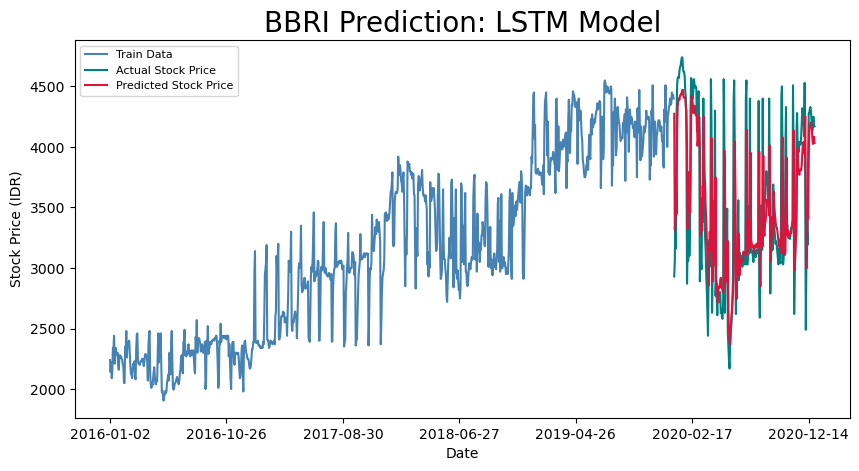

In [30]:
bbri_lstm_train = bbri[:bbri_train_len]
bbri_lstm_valid = bbri[bbri_train_len:]
bbri_lstm_valid['Predictions'] = bbri_pred

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bbri_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bbri_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bbri_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BBRI Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.savefig('BBRI LSTM.png')
plt.show()

In [31]:
mse = mean_squared_error(bbri_pred, bbri_lstm_y_test)
print(f'MSE: {mse}')
rmse = math.sqrt(mean_squared_error(bbri_pred, bbri_lstm_y_test))
print(f'RMSE: {rmse}')

MSE: 212979.60746399948
RMSE: 461.4971370052034


**Manual Tuning**

Saya akan menentukan banyaknya jumlah neuron yang akan digunakan pada LSTM berdasarkan rumus berikut.

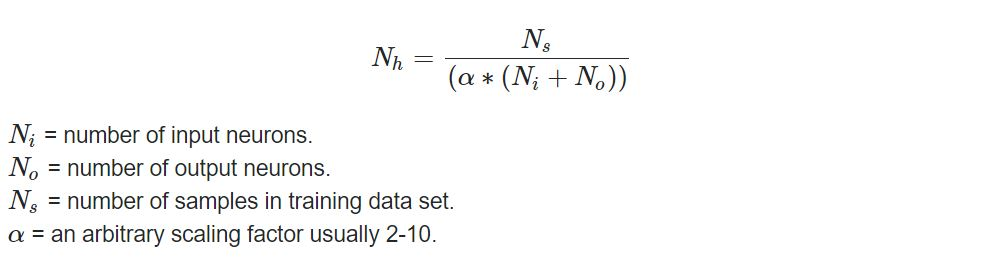

In [32]:
display.Image('./layer_formula.png', width = 600)

Referensi: https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

Dengan parameter:
- Jumlah input adalah 51.
- Jumlah output adalah 1
- Jumlah sampel adalah 969 (sebanyak training data)
- Nilai alpha yang saya gunakan adalah 2

Sehingga diperoleh jumlah layer sebanyak 10 layer.

In [33]:
bbri_lstm_tuned = Sequential()
bbri_lstm_tuned.add(LSTM(10, return_sequences = False, input_shape = (bbri_lstm_x_train.shape[1], 1)))
bbri_lstm_tuned.add(Dropout(0.2))
bbri_lstm_tuned.add(Dense(bbri_lstm_y_train.shape[1]))

bbri_lstm_tuned.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [34]:
bbri_lstm_tuned.fit(bbri_lstm_x_train, bbri_lstm_y_train, batch_size = 32, epochs = 100)

Epoch 1/100
29/29 [==============================] - 6s 25ms/step - loss: 0.1714
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 0.0384
Epoch 3/100
29/29 [==============================] - 1s 28ms/step - loss: 0.0267
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0213
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 0.0187
Epoch 6/100
29/29 [==============================] - 1s 31ms/step - loss: 0.0178
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0167
Epoch 8/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0180
Epoch 9/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0168
Epoch 10/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0163
Epoch 11/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0150
Epoch 12/100
29/29 [==============================] - 1s 26ms/step - loss: 0.0141
Epoch 13/100
29/29 [=====

In [35]:
bbri_pred_tuned = bbri_lstm_tuned.predict(bbri_lstm_x_test)
bbri_pred_tuned = scaler.inverse_transform(bbri_pred_tuned)

**Model Evaluation**

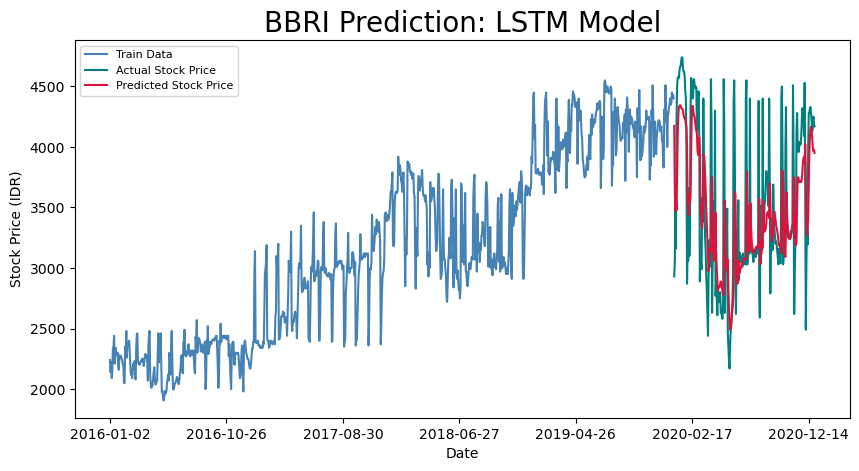

In [36]:
bbri_lstm_train = bbri[:bbri_train_len]
bbri_lstm_valid = bbri[bbri_train_len:]
bbri_lstm_valid['Predictions'] = bbri_pred_tuned

plt.figure(figsize = (10,5), dpi = 100)

plt.plot(bbri_lstm_train['Close'], label = 'Train Data', color = 'steelblue')
plt.plot(bbri_lstm_valid['Close'], label = 'Actual Stock Price', color = 'teal')
plt.plot(bbri_lstm_valid['Predictions'], label = 'Predicted Stock Price', color = 'crimson')

plt.title('BBRI Prediction: LSTM Model', size = 20)
plt.xticks(ticks = [0, 200, 400, 600, 800, 1000, 1200])
plt.xlabel('Date')
plt.ylabel('Stock Price (IDR)')
plt.legend(loc = 'upper left', fontsize = 8)

plt.show()

In [37]:
mse_tuned = mean_squared_error(bbri_pred_tuned, bbri_lstm_y_test)
print(f'MSE: {mse_tuned}')
rmse_tuned = math.sqrt(mean_squared_error(bbri_pred_tuned, bbri_lstm_y_test))
print(f'RMSE: {rmse_tuned}')

MSE: 239917.85807112427
RMSE: 489.81410562694526


**Result Comparison**

In [38]:
pd.set_option('display.float_format', '{:.2f}'.format)
lstm_compare = {'Evaluation Method': ['MSE', 'RMSE'], 'Random Parameter' : [mse, rmse], 'Manual Tuning' : [mse_tuned, rmse_tuned]}
pd.DataFrame(lstm_compare)

,Evaluation Method,Random Parameter,Manual Tuning
0,MSE,212979.61,239917.86
1,RMSE,461.50,489.81


In [39]:
rmse_ratio = rmse/ bbri_lstm_valid['Close'].mean()
rmse_tuned_ratio = rmse_tuned/ bbri_lstm_valid['Close'].mean()

In [40]:
print(f'Rasio RMSE (Random Parameter) dengan rata-rata harga saham BBRI (validation price mean) adalah {round(rmse_ratio, 5)}.')
print(f'Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah {round(rmse_tuned_ratio, 5)}.')

Rasio RMSE (Random Parameter) dengan rata-rata harga saham BBRI (validation price mean) adalah 0.13105.
Rasio RMSE (Manual Tuning) dengan rata-rata harga saham BBRI (validation price mean) adalah 0.13909.


Prediksi harga saham BBRI menggunakan model LSTM dengan random parameter memberikan hasil prediksi yang paling baik.

</br>

### 5. Deployment

Model LSTM dengan random parameter memberikan nilai RMSE yang paling kecil (nilai prediksinya baik dan mendekati harga saham sesungguhnya). Oleh karena itu, saya akan menyimpan model tersebut untuk digunakan dalam deployment selanjutnya.

In [41]:
bbri_lstm.save('bbri_lstm_model.h5')